In [57]:
%matplotlib inline
import pylab as plt
import jax.numpy as jnp
import seaborn as snb

from scipy.stats import binom as binom_dist
from scipy.stats import beta as beta_dist
from scipy.special import beta as beta_fun
from scipy.special import binom 

snb.set_style('darkgrid')
snb.set(font_scale=1.5)
plt.rcParams['lines.linewidth'] = 3
#jupyter nbconvert test_exam_2024.ipynb --to webpdf


import jax.numpy as jnp
import numpy as np # Often needed for defining the initial grid ranges
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as plt
import jax.numpy as jnp
import seaborn as snb
snb.set_style('darkgrid')
snb.set(font_scale=1.5)
plt.rcParams['lines.linewidth'] = 3
#jupyter nbconvert test_exam_2024.ipynb --to webpdf



## Part 1

Consider the following regression model

$$
y(x) = f(x) + e = w_0 + w_1x^2 + w_2 \sin{x} + w_3x + e,
$$

such that $y_n = f(x_n) + e_n$, where $x_n, y_n \in \mathbb{R}$ are input and targets, respectively. The additive noise $e_n \in \mathbb{R}$ is assumed to be i.i.d from a zero-mean Gaussian distribution, i.e. $e_n \sim \mathcal{N}(0, \beta^{-1})$ for $\beta > 0$.

Let 

$$
\mathbf{x} = [2.29, -1.8, -0.06, 3.72, 2.6, -5.93, -0.15]
$$

and 

$$
\mathbf{y} = [3.17, -4.53, -0.78, 3.15, 4.76, -1.96, -1.32]
$$

denote the vector of inputs and targets, respectively, for a dataset with $N=5$ observations.

Let 

$$
\mathbf{w} = [w_0, w_1, w_2, w_3] \in \mathbb{R}^4
$$

denote the parameter vector.

---

### Question 1.1:

> Compute and report a maximum likelihood estimate for $\mathbf{w}$ and $\beta$. \
>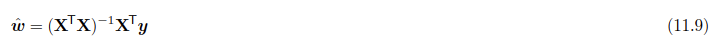 \
>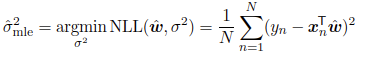


In [21]:
# X: shape (7, 1), column vector of inputs
X = jnp.array([2.29, -1.8, -0.06, 3.72, 2.6, -5.93, -0.15])[: , None]

# y: shape (7, 1), column vector of targets
y = jnp.array([3.17, -4.53, -0.78, 3.15, 4.76, -1.96, -1.32])[:, None]

def design_matrix(x):
    """
    Constructs the design matrix for the regression model.
    Input:
        x: shape (N, 1), column vector of inputs
    Output:
        design: shape (N, 4), where each column is:
            - column 0: 1 (bias term)
            - column 1: x^2
            - column 2: sin(x)
            - column 3: x
    Equation:
        For each input x_n, the row is [1, x_n^2, sin(x_n), x_n]
    """
    return jnp.column_stack([jnp.ones(len(x)), x**2, jnp.sin(x), x])

# design: shape (7, 4)
design = design_matrix(X)
#print(design)

# Compute the maximum likelihood estimate (MLE) for w:
# Equation: w_ML = (X^T X)^{-1} X^T y
# design.T @ design: shape (4, 4)
# design.T @ y: shape (4, 1)
# w_map: shape (4, 1), estimated weights
w_map = jnp.linalg.solve(design.T @ design, design.T @ y )


print(f"The MAP estimate is: ")
print(w_map)


The MAP estimate is: 
[[-0.73483545]
 [ 0.11247995]
 [ 2.3575475 ]
 [ 1.0124775 ]]


In [23]:
# Compute the residual sum of squares (RSS)
# Equation: RSS = sum_{n=1}^N (y_n - f(x_n; w_map))^2
# Input:
#   y: shape (N, 1), observed targets
#   design: shape (N, 4), design matrix
#   w_map: shape (4, 1), estimated weights
# Output:
#   rss: scalar, sum of squared residuals
rss = jnp.sum((y - design @ w_map) ** 2)

# Compute the maximum likelihood estimate for beta (noise precision)
# Equation: beta_ML = N / RSS
# Input:
#   rss: scalar, residual sum of squares
#   X: shape (N, 1), input data (used for N)
# Output:
#   beta_mle: scalar, estimated noise precision
beta_mle = len(X) / rss

print(f"The sigma^2 estimate is: ")
print(beta_mle)

The sigma^2 estimate is: 
4.841266


### Question 1.1:

Compute the posterior predictive distribution $ p(y^* \mid y, x^* = 1) $, where $ y^* = y(x^*) $ using a plug-in approximation based on the maximum likelihood estimators for $ \mathbf{w} $ and $ \beta $. Report the mean, standard deviation and a 95\% credibility interval for $ y^* $.


In [24]:
x_star = jnp.array([1])

y_star = design_matrix(x_star) @ w_map

print(f"The predicted value is: ")
print(y_star)


The predicted value is: 
[[2.37393]]


In [25]:
std_dev = 1 / jnp.sqrt(beta_mle)
print(f"The standard deviation is: {std_dev}")

The standard deviation is: 0.4544859826564789


In [27]:
# confidence intervals 

low = y_star - 1.96 * std_dev
high = y_star + 1.96 * std_dev

print(f"The confidence interval is: ")
print(f"({low}, {high})")

# alternative use norm.interval 
from scipy.stats import norm
# Compute the confidence interval for the predicted value
# Equation: y_star ± 1.96 * std_dev
y_star_lower, y_star_upper = norm.interval(0.95, loc=y_star, scale=std_dev)

print(f"The confidence interval using scipy is: ")
print(f"({y_star_lower}, {y_star_upper})")


The confidence interval is: 
([[1.4831374]], [[3.2647226]])
The confidence interval using scipy is: 
([[1.48315382]], [[3.26470613]])


Next, we impose i.i.d Gaussian priors on all regression coefficients $ w_j \sim \mathcal{N}(0, \alpha^{-1}) $ for $ j = 0,1,2,3 $ and assume $ \alpha = 1 $ and $ \beta = \frac{1}{2} $.

### Question 1.3: 
Compute and report the posterior mean and marginal posterior standard deviation for each regression coefficient in $ \mathbf{w} $.


In [31]:
# This class implements Bayesian Linear Regression.
# It computes the posterior distribution over the weights
# given the design matrix (Phi) and the observed targets (y).
class BayesianLinearRegression(object):
    
    def __init__(self, Phi, y, alpha=1., beta=1.):
        # Store the design matrix and output vector. 
        # Phi is the input matrix where each row is an observation and each column is a feature.
        # y is the corresponding vector of outputs/responses.
        # Input shapes:
        #   Phi: (N, D)
        #   y:   (N, 1)
        self.Phi, self.y = Phi, y
        # Determine the number of observations (N) and number of features (D)
        self.N, self.D = Phi.shape
        # Store the hyperparameters:
        # alpha is the precision (inverse variance) of the weight prior.
        # beta is the precision (inverse variance) of the noise in the data.
        self.alpha, self.beta = alpha, beta
        
        # Compute the posterior distribution parameters (mean and covariance) of the weights.
        self.m, self.S = self.compute_posterior(alpha, beta)
        # Also compute the log marginal likelihood of the observed data.
        self.log_marginal_likelihood = self.compute_marginal_likelihood(alpha, beta)

        # Perform sanity checks to ensure dimensions of computed quantities are correct.
        self.check_dimensions()

    def check_dimensions(self):
        # Use D as the number of parameters/weights.
        D = self.D
        # Assert that the shape of y is (N, 1).
        # The message shows the expected shape using the number of data points (N).
        assert self.y.shape == (self.N, 1), f"Wrong shape for data vector y.\n For N = {self.N}, the shape of y must be ({self.N}, 1), but the actual shape is {self.y.shape}"
        # Check the posterior mean has expected dimensions (D, 1)
        assert self.m.shape == (D, 1), f"Wrong shape for posterior mean.\nFor D = {D}, the shape of the posterior mean must be ({D}, 1), but the actual shape is {self.m.shape}"
        # Check that the posterior covariance matrix has dimensions (D, D)
        assert self.S.shape == (D, D), f"Wrong shape for posterior covariance.\nFor D = {D}, the shape of the posterior covariance must be ({D}, {D}), but the actual shape is {self.S.shape}"

    # Function to compute the posterior mean and covariance of the weights.
    # The posterior distribution is a normal distribution N(w|m, S).
    # Input: 
    #   alpha: scalar
    #   beta: scalar
    # Output:
    #   m: (D, 1) posterior mean
    #   S: (D, D) posterior covariance
    # Equations:
    #   S = (alpha * I + beta * Phi^T * Phi)^(-1)
    #   m = beta * S * Phi^T * y
    def compute_posterior(self, alpha, beta):
        """ computes the posterior N(w|m, S) and return m, S.
            Shape of m and S must be (D, 1) and (D, D), respectively  """
        
        S_0 = 1 / alpha * jnp.eye(self.D)  # (D, D)
        S_0_inv = jnp.linalg.inv(S_0)      # (D, D)

        A = S_0_inv + beta * self.Phi.T @ self.Phi  # (D, D)
        S = jnp.linalg.inv(A)                       # (D, D)

        m = (beta *  S) @ self.Phi.T @ self.y       # (D, 1)

        return m, S
      
    # Function to generate samples from the prior distribution over weights.
    # It uses a multivariate normal distribution where the covariance is scaled by 1/alpha.
    # Input:
    #   key: PRNG key
    #   num_samples: int
    # Output:
    #   samples: (num_samples, D)
    def generate_prior_samples(self, key, num_samples):
        """ generate samples from the prior  """
        return random.multivariate_normal(key, jnp.zeros(len(self.m)), (1/self.alpha)*jnp.identity(len(self.m)), shape=(num_samples, ))
    
    # Function to generate samples from the posterior distribution over weights.
    # Input:
    #   key: PRNG key
    #   num_samples: int
    # Output:
    #   samples: (num_samples, D)
    def generate_posterior_samples(self, key, num_samples):
        """ generate samples from the posterior  """
        # Samples are drawn from a multivariate normal with mean m and covariance S.
        # .ravel() is used to convert m into a 1d array.
        return random.multivariate_normal(key, self.m.ravel(), self.S, shape=(num_samples, ))
    
    # Function to compute the predictive distribution (mean and variance) for the latent function f.
    # Given a new design matrix Phi, it computes the mean and variance of the function outputs.
    # Input:
    #   Phi: (N, D)
    # Output:
    #   mu_f: (N,)
    #   var_f: (N,)
    # Equations:
    #   mu_f = Phi @ m
    #   var_f = diag(Phi @ S @ Phi^T)
    def predict_f(self, Phi):
        """ computes posterior mean (mu_f) and variance (var_f) of f(phi(x)) for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_f and var_f must be (N,)
            The function returns (mu_f, var_f)
        """
        # Compute the predictive mean for the latent function.
        mu_f = (Phi @ self.m).ravel()  # (N,)
        # Compute the predictive variance for the latent function.
        var_f = jnp.diag(Phi @ self.S @ Phi.T)  # (N,)

        # Sanity checks to ensure the outputs have the correct shape.
        assert mu_f.shape == (Phi.shape[0],), "Shape of mu_f seems wrong. Check your implementation"
        assert var_f.shape == (Phi.shape[0],), "Shape of var_f seems wrong. Check your implementation"
        return mu_f, var_f
        
    # Function to compute the predictive distribution (mean and variance) for the actual outputs y.
    # It incorporates the noise variance from the likelihood.
    # Input:
    #   Phi: (N, D)
    # Output:
    #   mu_y: (N,)
    #   var_y: (N,)
    # Equations:
    #   mu_y = mu_f
    #   var_y = var_f + 1/beta
    def predict_y(self, Phi):
        """ returns posterior predictive mean (mu_y) and variance (var_y) of y = f(phi(x)) + e for each row in Phi-matrix.
            If Phi is a [N, D]-matrix, then the shapes of both mu_y and var_y must be (N,).
            The function returns (mu_y, var_y)
        """
        # Get the predictive mean and variance for the latent function f.
        mu_f, var_f = self.predict_f(Phi)
        # Compute the mean for the observed output y.
        mu_y = mu_f
        # Compute the variance for y; note that the noise variance (1/beta) needs to be added.
        var_y = var_f + 1 / self.beta

        # Verify that the computed predictions have the correct dimensions.
        assert mu_y.shape == (Phi.shape[0],), "Shape of mu_y seems wrong. Check your implementation"
        assert var_y.shape == (Phi.shape[0],), "Shape of var_y seems wrong. Check your implementation"
        return mu_y, var_y
        
    # Function to compute the log marginal likelihood of the data.
    # This value can be used for model selection and hyperparameter tuning.
    # The implementation is based on equations from Bishop's book.
    # Input:
    #   alpha: scalar
    #   beta: scalar
    # Output:
    #   log marginal likelihood: scalar
    # Equation: See Bishop eq. 3.86
    def compute_marginal_likelihood(self, alpha, beta):
        """ computes and returns log marginal likelihood p(y|alpha, beta) """
        # Prior precision matrix (diagonal matrix with alpha on the diagonal)
        inv_S0 = alpha*jnp.identity(self.D)
        # Compute the posterior precision matrix A using the design matrix.
        A = inv_S0 + beta*(self.Phi.T@self.Phi)
        # Compute the posterior mean using a linear system solve for numerical stability.
        m = beta*jnp.linalg.solve(A, self.Phi.T)@self.y   # (eq. 3.53 in Bishop)
        # Compute the posterior covariance matrix as the inverse of A.
        S = jnp.linalg.inv(A)                             # (eq. 3.54 in Bishop)
        # Compute the energy term which combines the residual error and the prior.
        Em = beta/2*jnp.sum((self.y - self.Phi@m)**2) + alpha/2*jnp.sum(m**2)
        # Compute the log marginal likelihood using determinants and constants.
        return self.D/2*jnp.log(alpha) + self.N/2*jnp.log(beta) - Em - 0.5*jnp.linalg.slogdet(A)[1] - self.N/2*jnp.log(2*jnp.pi)
         
    # Function to optimize the hyperparameters (alpha and beta) by maximizing the marginal likelihood.
    def optimize_hyperparameters(self):
        # Initialize the parameters in the log domain for better stability during optimization.
        theta0 = jnp.array((jnp.log(self.alpha), jnp.log(self.beta)))
        # Define the negative marginal likelihood function and its gradient.
        def negative_marginal_likelihood(theta):
            # Convert back to the original scale using exponentiation.
            alpha, beta = jnp.exp(theta[0]), jnp.exp(theta[1])
            return -self.compute_marginal_likelihood(alpha, beta)

        # Optimize the negative marginal likelihood using a gradient-based optimizer.
        result = minimize(value_and_grad(negative_marginal_likelihood), theta0, jac=True)

        # Store the optimized hyperparameters and update the posterior distribution.
        theta_opt = result.x
        self.alpha, self.beta = jnp.exp(theta_opt[0]), jnp.exp(theta_opt[1])
        self.m, self.S = self.compute_posterior(self.alpha, self.beta)
        self.log_marginal_likelihood = self.compute_marginal_likelihood(self.alpha, self.beta)

# Sanity check of implementation.
# Here, we use a toy example with a 2x2 design matrix and 2x1 responses.
# The assertions verify that the computed posterior mean and covariance are correct.
model = BayesianLinearRegression(0.5*jnp.ones((2,2)), 2*jnp.ones((2, 1)), alpha=0.5, beta=0.5)       
assert jnp.allclose(model.m, jnp.array([1, 1])), "Something seems to be wrong with your implementation of the posterior mean. Please check your implementation." 
assert jnp.allclose(model.S, jnp.array([[1.5, -0.5], [-0.5, 1.5]])), "Something seems to be wrong with your implementation of the posterior covariance. Please check your implementation." 


In [47]:
beta = 0.5 
# imporr the normal dstribution 
alpha = 1 


# Fit model to the training toy dataset.
# 'design_matrix' is a function (or variable) defined elsewhere that creates the design matrix.
Phi_train = design_matrix(X)
model = BayesianLinearRegression(Phi_train, y, alpha, beta)

#print(f"Phi shape: {Phi_train.shape}")
#print("Phi: ", Phi_train)


mu, S = model.compute_posterior(alpha, beta)

print(f"Mean of the posterior: \n{mu}")
print(f"Covariance of the posterior: \n{S}")

Mean of the posterior: 
[[-0.5580299 ]
 [ 0.10888302]
 [ 1.2586912 ]
 [ 0.98545694]]
Covariance of the posterior: 
[[ 0.36851704 -0.01991333  0.0599144  -0.04446302]
 [-0.01991333  0.00271534 -0.00727841  0.005746  ]
 [ 0.05991439 -0.00727841  0.49409547 -0.02089094]
 [-0.04446298  0.00574599 -0.02089094  0.04242343]]


In [48]:
posterior_mean = model.m.ravel()  # shape: (2,)
posterior_covariance = model.S    # shape: (2, 2)

print(f"Posterior Covariance {posterior_covariance}")
print(f"Posterior mean {posterior_mean}")

# Extract diagonal elements (variances) from the covariance matrix
print(f"Diagonals from the Covariance Matrix {jnp.diag(posterior_covariance)}")

# Compute standard deviations for each parameter (sqrt of variances)
std_dev = jnp.sqrt(jnp.diag(posterior_covariance))  # shape: (2,)


Posterior Covariance [[ 0.36851704 -0.01991333  0.0599144  -0.04446302]
 [-0.01991333  0.00271534 -0.00727841  0.005746  ]
 [ 0.05991439 -0.00727841  0.49409547 -0.02089094]
 [-0.04446298  0.00574599 -0.02089094  0.04242343]]
Posterior mean [-0.5580299   0.10888302  1.2586912   0.98545694]
Diagonals from the Covariance Matrix [0.36851704 0.00271534 0.49409547 0.04242343]


In [49]:
Phi = design_matrix(jnp.array([1]))

print(Phi)

mu_pred, var_pred = model.predict_y(Phi)

print(f"Mean of the posterior predictive distribution: {mu_pred}")
print(f"Variance of the posterior predictive distribution: {var_pred}")

[[1.         1.         0.84147096 1.        ]]
Mean of the posterior predictive distribution: [1.5954621]
Variance of the posterior predictive distribution: [2.699676]


In [51]:
marginal_likelihood = model.compute_marginal_likelihood(alpha, beta)
print(f"Log marginal likelihood: {marginal_likelihood}")

Log marginal likelihood: -17.242862701416016


In [53]:
from scipy.stats import gamma

def log_hyperpriors(thetas):
    alpha = thetas[0]
    beta = thetas[1]
    
    if jnp.any(thetas <= 0):
        return -jnp.inf 
    
    log_p_alpha = gamma.logpdf(alpha, a=1, scale=1)
    log_p_beta = gamma.logpdf(beta, a=1, scale=1)
    
    likelihood = model.compute_marginal_likelihood(alpha, beta)
    
    return log_p_alpha + log_p_beta + likelihood

In [61]:
import jax.numpy as jnp
import numpy as np
from jax import value_and_grad
from jax import random
from scipy.optimize import minimize
import pylab as plt
from scipy.stats import multivariate_normal as mvn
def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):    
    """ Runs a Metropolis-Hastings sampler 

        Arguments:
        log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
        num_params:         number of parameters of the joint distribution (integer)
        tau:                standard deviation of the Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 

    # set initial key
    key = random.PRNGKey(seed)

    # if there is no theta init, it starts with zero
    # theta init is \theta^{k-1}
    if theta_init is None:

        theta_init = jnp.zeros((num_params))
        print(f"Shape of theta init {theta_init.shape} is the same as a number of parameters {num_params}")
    # prepare lists 
    thetas = [theta_init] # list to store all samples, starting with the initial 
    accepts = [] # list of accepted proposals 
    log_p_theta = log_target(theta_init) # log probability of the initial position 

    for k in range(num_iter):
        
        

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        ##############################################
        # Your solution goes here
        ##############################################
        # Get the current state theta^{(k)} from the end of the list 
        theta_current = thetas[-1] # current position of the chain, \theta^{k-1}
        
        # 1. Propose a new state theta' ~ q(theta' | theta_current)
        # Draw from N(theta_current, tau^2 * I)
        noise = random.normal(key_proposal, shape=(num_params))
        theta_proposal = theta_current + tau * noise
        
        log_p_theta_proposal = log_target(theta_proposal)
        
        log_acceptance_ratio = log_p_theta_proposal - log_p_theta 
        
        u = random.uniform(key_accept)
        
        accept = jnp.log(u) < jnp.minimum(0.0, log_acceptance_ratio)
        
        if accept:
            thetas.append(theta_proposal)
            log_p_theta = log_p_theta_proposal
            accepts.append(1.)
        else: 
            thetas.append(theta_current)
            accepts.append(0)
        
        

        ##############################################
        # End of solution
        ##############################################

    print('Acceptance ratio: %3.2f' % jnp.mean(jnp.array(accepts)))

    # return as np.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (num_iter+1, num_params), f'The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code.'
    return thetas

In [64]:
log_joint = lambda theta: log_hyperpriors(theta)

In [80]:
NUM_ITTER = 2000
NUM_PARAMS = 2
THETA_INIT_1 = jnp.array([1, 1])
TAU = 1

# Run the Metropolis MCMC sampler
# Inputs:
#   log_target: function that takes a parameter vector theta (shape: (2,)) and returns log-posterior (scalar)
#   num_params: number of parameters (int, here 2)
#   tau: proposal stddev (float, here 1)
#   num_iter: number of MCMC iterations (int, here 10000)
#   theta_init: initial parameter vector (shape: (2,))
# Output:
#   thetas: array of sampled parameter vectors (shape: (num_iter, 2))
# Equation for proposal: q(z^* | z) = N(z^* | z, I)
thetas = metropolis(
    log_target=log_joint,  # log-posterior function, input: theta (shape (2,)), output: scalar
    num_params=NUM_PARAMS,     # number of parameters (2)
    tau=TAU,                   # proposal stddev
    num_iter=NUM_ITTER,         # number of MCMC iterations
    theta_init=THETA_INIT_1,      # initial parameter vector (shape (2,))
    seed=123
)


Acceptance ratio: 0.33
Lengh of the warmup period = 200


In [81]:
NUM_ITTER = 2000
NUM_PARAMS = 2
THETA_INIT_2 = jnp.array([10, 10])
TAU = 1

# Run the Metropolis MCMC sampler
# Inputs:
#   log_target: function that takes a parameter vector theta (shape: (2,)) and returns log-posterior (scalar)
#   num_params: number of parameters (int, here 2)
#   tau: proposal stddev (float, here 1)
#   num_iter: number of MCMC iterations (int, here 10000)
#   theta_init: initial parameter vector (shape: (2,))
# Output:
#   thetas: array of sampled parameter vectors (shape: (num_iter, 2))
# Equation for proposal: q(z^* | z) = N(z^* | z, I)
thetas_2 = metropolis(
    log_target=log_joint,  # log-posterior function, input: theta (shape (2,)), output: scalar
    num_params=NUM_PARAMS,     # number of parameters (2)
    tau=TAU,                   # proposal stddev
    num_iter=NUM_ITTER,         # number of MCMC iterations
    theta_init=THETA_INIT_2,      # initial parameter vector (shape (2,))
    seed=456
)

Acceptance ratio: 0.33


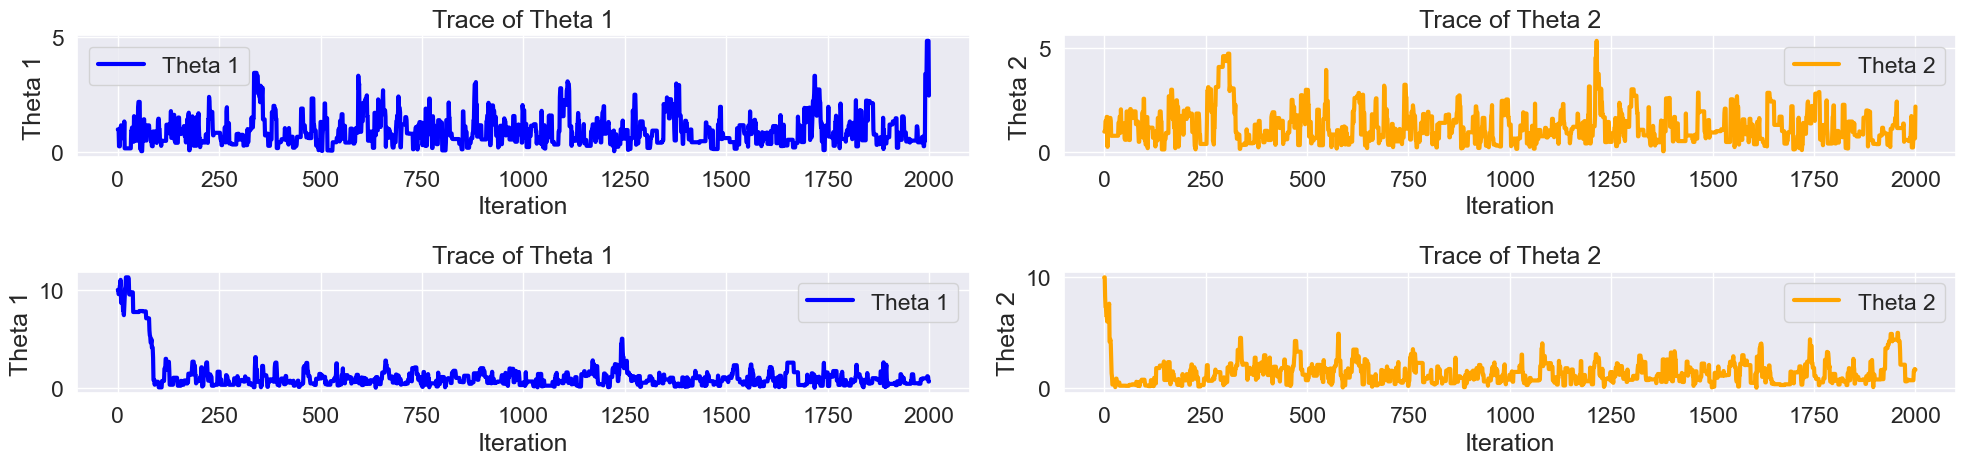

In [82]:
# plot the traces for theta and theta 1 



# traces now 

fig, axes = plt.subplots(2, 2, figsize=(20, 5))

# Plot the first parameter (theta[0]) 
axes[0, 0].plot(thetas[:, 0], label='Theta 1', color='blue')
axes[0, 0].set_title('Trace of Theta 1')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Theta 1')
axes[0, 0].legend()
# Plot the second parameter (theta[1])
axes[0, 1].plot(thetas[:, 1], label='Theta 2', color='orange')
axes[0, 1].set_title('Trace of Theta 2')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Theta 2')
axes[0, 1].legend()
# Plot the first parameter (theta[0])

axes[1, 0].plot(thetas_2[:, 0], label='Theta 1', color='blue')
axes[1, 0].set_title('Trace of Theta 1')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Theta 1')
axes[1, 0].legend()
# Plot the second parameter (theta[1])
axes[1, 1].plot(thetas_2[:, 1], label='Theta 2', color='orange')
axes[1, 1].set_title('Trace of Theta 2')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Theta 2')
axes[1, 1].legend()
plt.tight_layout()
plt.show()


In [91]:
print(f"Shape of thetas {thetas.shape}")
print(f"Shape of thetas {thetas_2.shape}")

combined_samples = jnp.vstack([thetas[500:], thetas_2[500:]])
print(f"Shape of combined samples {combined_samples.shape}")

posterior_means = combined_samples.mean(axis=0)
posterior_std = combined_samples.std(axis=0)

alpha_mean = posterior_means[0]
alpha_std = posterior_std[0]
beta_mean = posterior_means[1]
beta_std = posterior_std[1]

print(f"alpha = {alpha_mean}")
print(f"beta = {beta_mean}")

print(f"alpha std = {alpha_std}")
print(f"beta std = {beta_std}")


Shape of thetas (2001, 2)
Shape of thetas (2001, 2)
Shape of combined samples (3002, 2)
alpha = 0.9342095851898193
beta = 1.2624247074127197
alpha std = 0.6369702816009521
beta std = 0.8282010555267334


In [92]:
from scipy.stats import beta

In [ ]:
import numpy as np
from scipy.stats import beta

# Parameters for the two components
a_1, b_1 = 2, 10
a_2, b_2 = 10, 2

# Number of samples to draw
n_samples = 100000

# First, we need to draw samples from the mixture distribution
# We'll do this by:
# 1. Randomly choosing which component to sample from (based on weights 3/7 and 4/7)
# 2. Drawing from the chosen component

# Generate component indicators (0 for first component, 1 for second)
component_indicators = np.random.choice([0, 1], size=n_samples, p=[3/7, 4/7])

# Initialize array for samples
samples = np.zeros(n_samples)

# Draw samples
for i in range(n_samples):
    if component_indicators[i] == 0:
        samples[i] = beta.rvs(a_1, b_1)
    else:
        samples[<Whi] = beta.rvs(a_2, b_2)

# Count how many samples are greater than 0.5
count_greater_than_half = np.sum(samples > 0.5)

# Estimate the probability
prob_estimate = count_greater_than_half / n_samples

print(f"The estimated probability of θ > 1/2 is: {prob_estimate:.6f}")

The estimated probability of θ > 1/2 is: 0.570480


Method 1: Using CDFs
--------------------
P(X > 0) for Standard Normal: 0.500000
P(-1 < X < 1) for Standard Normal: 0.682689
P(X > 0.5) for Beta(2,5): 0.109375
P(X < 2) for Exp(1): 0.864665

Method 2: Using scipy.integrate.quad
------------------------------------
P(X > 0) for Standard Normal: 0.500000
P(-1 < X < 1) for Mixture: 0.157305

Method 3: Monte Carlo Integration
---------------------------------
P(X > 0) for Standard Normal: 0.499880
P(X > 0.5) for Beta(2,5): 0.108290
P(-1 < X < 1) for Mixture: 0.158920

Advanced: Custom Distribution Class
-----------------------------------
P(X > 0) for Truncated Normal[-2,2]: 0.500000


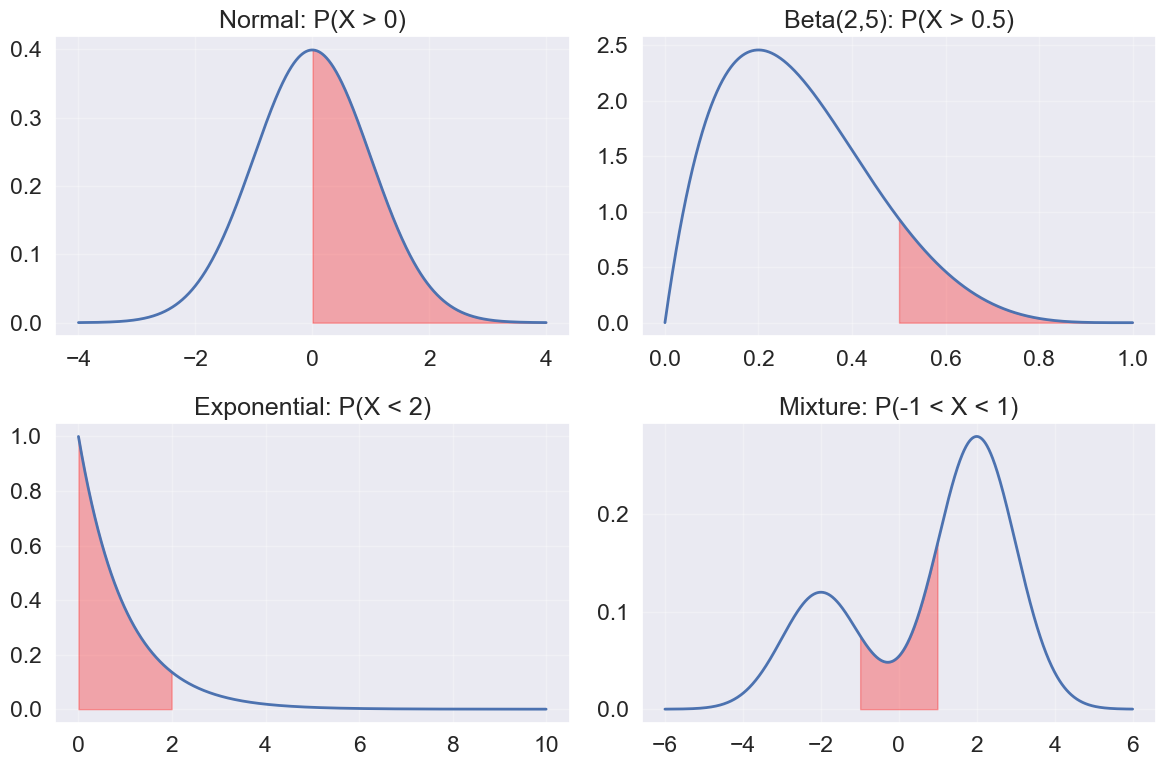


PROBABILITY INTEGRATION CHEAT SHEET

1. For Standard Distributions (Normal, Beta, Exponential, etc.):
   - Use scipy.stats CDFs: dist.cdf(b) - dist.cdf(a)
   - Most efficient and accurate method

2. For Custom PDFs or Mixtures:
   - Use scipy.integrate.quad: quad(pdf_func, a, b)
   - Works for any function you can define

3. For Complex/High-Dimensional Cases:
   - Use Monte Carlo: Generate samples and count
   - Becomes more efficient in higher dimensions

4. Special Cases:
   - P(X > a) = 1 - CDF(a)
   - P(X < b) = CDF(b)
   - P(X = a) = 0 for continuous distributions

5. Common Pitfalls:
   - Remember PDF values can exceed 1
   - Integration bounds matter (especially for infinity)
   - Check if distribution is properly normalized



In [129]:
import numpy as np
from scipy import stats
from scipy.integrate import quad
import matplotlib.pyplot as plt

# ===========================
# Method 1: Using CDFs (Most Efficient)
# ===========================

def prob_using_cdf(dist, a, b):
    """
    Calculate P(a < X < b) using CDF
    dist: scipy.stats distribution object
    a: lower bound (use -np.inf for no lower bound)
    b: upper bound (use np.inf for no upper bound)
    """
    return dist.cdf(b) - dist.cdf(a)

# Examples:
print("Method 1: Using CDFs")
print("--------------------")

# Normal distribution
normal_dist = stats.norm(loc=0, scale=1)
print(f"P(X > 0) for Standard Normal: {prob_using_cdf(normal_dist, 0, np.inf):.6f}")
print(f"P(-1 < X < 1) for Standard Normal: {prob_using_cdf(normal_dist, -1, 1):.6f}")

# Beta distribution
beta_dist = stats.beta(a=2, b=5)
print(f"P(X > 0.5) for Beta(2,5): {prob_using_cdf(beta_dist, 0.5, 1):.6f}")

# Exponential distribution
exp_dist = stats.expon(scale=1)
print(f"P(X < 2) for Exp(1): {prob_using_cdf(exp_dist, 0, 2):.6f}")

# ===========================
# Method 2: Numerical Integration with scipy.integrate.quad
# ===========================

def prob_using_quad(pdf_func, a, b):
    """
    Calculate P(a < X < b) using numerical integration
    pdf_func: PDF function
    a: lower bound
    b: upper bound
    """
    result, error = quad(pdf_func, a, b)
    return result

# Examples:
print("\nMethod 2: Using scipy.integrate.quad")
print("------------------------------------")

# Normal distribution
print(f"P(X > 0) for Standard Normal: {prob_using_quad(lambda x: stats.norm.pdf(x), 0, np.inf):.6f}")

# Custom mixture distribution
def mixture_pdf(x):
    return 0.3 * stats.norm.pdf(x, -2, 1) + 0.7 * stats.norm.pdf(x, 2, 1)

print(f"P(-1 < X < 1) for Mixture: {prob_using_quad(mixture_pdf, -1, 1):.6f}")

# ===========================
# Method 3: Monte Carlo Integration (Sampling)
# ===========================

def prob_using_monte_carlo(sampler, condition_func, n_samples=100000):
    """
    Calculate probability using Monte Carlo sampling
    sampler: function that generates samples
    condition_func: function that returns True if condition is met
    n_samples: number of samples to generate
    """
    samples = sampler(n_samples)
    return np.mean(condition_func(samples))

# Examples:
print("\nMethod 3: Monte Carlo Integration")
print("---------------------------------")

# Normal distribution
normal_sampler = lambda n: np.random.normal(0, 1, n)
print(f"P(X > 0) for Standard Normal: {prob_using_monte_carlo(normal_sampler, lambda x: x > 0):.6f}")

# Beta distribution
beta_sampler = lambda n: np.random.beta(2, 5, n)
print(f"P(X > 0.5) for Beta(2,5): {prob_using_monte_carlo(beta_sampler, lambda x: x > 0.5):.6f}")

# Mixture distribution
def mixture_sampler(n):
    component = np.random.choice([0, 1], size=n, p=[0.3, 0.7])
    samples = np.zeros(n)
    samples[component == 0] = np.random.normal(-2, 1, np.sum(component == 0))
    samples[component == 1] = np.random.normal(2, 1, np.sum(component == 1))
    return samples

print(f"P(-1 < X < 1) for Mixture: {prob_using_monte_carlo(mixture_sampler, lambda x: (-1 < x) & (x < 1)):.6f}")

# ===========================
# Advanced Example: Custom Distribution Class
# ===========================

class CustomDistribution:
    def __init__(self, pdf_func, domain=(-np.inf, np.inf)):
        self.pdf = pdf_func
        self.domain = domain
    
    def cdf(self, x):
        """Compute CDF at x"""
        if x <= self.domain[0]:
            return 0
        elif x >= self.domain[1]:
            return 1
        else:
            result, _ = quad(self.pdf, self.domain[0], x)
            return result
    
    def prob_between(self, a, b):
        """P(a < X < b)"""
        return self.cdf(b) - self.cdf(a)
    
    def prob_greater_than(self, a):
        """P(X > a)"""
        return 1 - self.cdf(a)
    
    def prob_less_than(self, b):
        """P(X < b)"""
        return self.cdf(b)

# Example with custom distribution
print("\nAdvanced: Custom Distribution Class")
print("-----------------------------------")

# Create a truncated normal distribution
def truncated_normal_pdf(x, mu=0, sigma=1, a=-2, b=2):
    if a <= x <= b:
        return stats.norm.pdf(x, mu, sigma) / (stats.norm.cdf(b, mu, sigma) - stats.norm.cdf(a, mu, sigma))
    return 0

trunc_norm = CustomDistribution(truncated_normal_pdf, domain=(-2, 2))
print(f"P(X > 0) for Truncated Normal[-2,2]: {trunc_norm.prob_greater_than(0):.6f}")

# ===========================
# Visualization Helper
# ===========================

def visualize_probability(dist, a, b, title="Probability Visualization"):
    """
    Visualize the probability P(a < X < b)
    dist: scipy.stats distribution or CustomDistribution
    """
    # Generate x values
    if hasattr(dist, 'ppf'):  # scipy.stats distribution
        x_min, x_max = dist.ppf(0.001), dist.ppf(0.999)
    else:  # Custom distribution
        x_min, x_max = dist.domain
    
    x = np.linspace(x_min, x_max, 1000)
    
    # Get PDF values
    if hasattr(dist, 'pdf'):  # scipy.stats distribution
        y = dist.pdf(x)
    else:  # Custom distribution
        y = np.array([dist.pdf(xi) for xi in x])
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', linewidth=2, label='PDF')
    
    # Fill the area of interest
    x_fill = x[(x >= a) & (x <= b)]
    y_fill = y[(x >= a) & (x <= b)]
    plt.fill_between(x_fill, y_fill, alpha=0.3, color='red', label=f'P({a:.2f} < X < {b:.2f})')
    
    # Add vertical lines
    if a > x_min:
        plt.axvline(x=a, color='red', linestyle='--', alpha=0.5)
    if b < x_max:
        plt.axvline(x=b, color='red', linestyle='--', alpha=0.5)
    
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualization example
plt.figure(figsize=(12, 8))

# Normal distribution
plt.subplot(2, 2, 1)
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x)
plt.plot(x, y, 'b-', linewidth=2)
x_fill = x[x > 0]
y_fill = stats.norm.pdf(x_fill)
plt.fill_between(x_fill, y_fill, alpha=0.3, color='red')
plt.title('Normal: P(X > 0)')
plt.grid(True, alpha=0.3)

# Beta distribution
plt.subplot(2, 2, 2)
x = np.linspace(0, 1, 1000)
y = stats.beta.pdf(x, 2, 5)
plt.plot(x, y, 'b-', linewidth=2)
x_fill = x[x > 0.5]
y_fill = stats.beta.pdf(x_fill, 2, 5)
plt.fill_between(x_fill, y_fill, alpha=0.3, color='red')
plt.title('Beta(2,5): P(X > 0.5)')
plt.grid(True, alpha=0.3)

# Exponential distribution
plt.subplot(2, 2, 3)
x = np.linspace(0, 10, 1000)
y = stats.expon.pdf(x)
plt.plot(x, y, 'b-', linewidth=2)
x_fill = x[x < 2]
y_fill = stats.expon.pdf(x_fill)
plt.fill_between(x_fill, y_fill, alpha=0.3, color='red')
plt.title('Exponential: P(X < 2)')
plt.grid(True, alpha=0.3)

# Mixture distribution
plt.subplot(2, 2, 4)
x = np.linspace(-6, 6, 1000)
y = 0.3 * stats.norm.pdf(x, -2, 1) + 0.7 * stats.norm.pdf(x, 2, 1)
plt.plot(x, y, 'b-', linewidth=2)
x_fill = x[(x > -1) & (x < 1)]
y_fill = 0.3 * stats.norm.pdf(x_fill, -2, 1) + 0.7 * stats.norm.pdf(x_fill, 2, 1)
plt.fill_between(x_fill, y_fill, alpha=0.3, color='red')
plt.title('Mixture: P(-1 < X < 1)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===========================
# Summary Cheat Sheet
# ===========================

print("\n" + "="*50)
print("PROBABILITY INTEGRATION CHEAT SHEET")
print("="*50)

print("""
1. For Standard Distributions (Normal, Beta, Exponential, etc.):
   - Use scipy.stats CDFs: dist.cdf(b) - dist.cdf(a)
   - Most efficient and accurate method

2. For Custom PDFs or Mixtures:
   - Use scipy.integrate.quad: quad(pdf_func, a, b)
   - Works for any function you can define

3. For Complex/High-Dimensional Cases:
   - Use Monte Carlo: Generate samples and count
   - Becomes more efficient in higher dimensions

4. Special Cases:
   - P(X > a) = 1 - CDF(a)
   - P(X < b) = CDF(b)
   - P(X = a) = 0 for continuous distributions

5. Common Pitfalls:
   - Remember PDF values can exceed 1
   - Integration bounds matter (especially for infinity)
   - Check if distribution is properly normalized
""")

In [139]:
# Mixture distribution
def mixture_sampler(n):
    component = np.random.choice([0, 1], size=n, p=[3/7, 4/7])
    samples = np.zeros(n)
    # use beta distribution
    samples[component == 0] = np.random.beta(2, 10, np.sum(component == 0))
    samples[component == 1] = np.random.beta(10, 2, np.sum(component == 1))
    return samples

In [140]:
beta = mixture_sampler(100000)

In [141]:
above_05 = jnp.mean(beta > 0.5)
print(f"Probability of beta > 0.5: {above_05:.6f}")

Probability of beta > 0.5: 0.570080


DISCRETE DISTRIBUTIONS

1. Bernoulli Distribution
-------------------------
P(X = 1) for Bernoulli(p=0.7): 0.700000
P(X = 0) for Bernoulli(p=0.7): 0.300000
P(X ≤ 0) for Bernoulli(p=0.7): 0.300000

2. Binomial Distribution
-------------------------
P(X = 5) for Binomial(n=10, p=0.3): 0.102919
P(X ≤ 5) for Binomial(n=10, p=0.3): 0.952651
P(3 ≤ X ≤ 7) for Binomial(n=10, p=0.3): 0.615627
P(X > 5) for Binomial(n=10, p=0.3): 0.047349

3. Poisson Distribution
-------------------------
P(X = 3) for Poisson(λ=3.5): 0.215785
P(X ≤ 5) for Poisson(λ=3.5): 0.857614
P(X > 5) for Poisson(λ=3.5): 0.142386

4. Categorical Distribution
-------------------------
P(category=2) for Categorical([0.2, 0.3, 0.1, 0.4]): 0.300000
P(X = category 2) using multinomial: 0.300000
Empirical P(category=2): 0.305400


CONTINUOUS DISTRIBUTIONS

5. Student's t-distribution
-------------------------
P(X > 0) for t(5): 0.500000
P(-2 < X < 2) for t(5): 0.898061
P(|X| > 2) for t(5): 0.101939

6. Gamma Distribution
----------

C:\Users\Petrb\AppData\Local\Temp\ipykernel_86988\91945720.py:209: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Petrb\AppData\Local\Temp\ipykernel_86988\91945720.py:209: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Petrb\AppData\Local\Temp\ipykernel_86988\91945720.py:209: UserWarning: Glyph 8323 (\N{SUBSCRIPT THREE}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Petrb\miniconda3\envs\02477_Bayes\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Petrb\miniconda3\envs\02477_Bayes\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Petrb\miniconda3\envs\02477_Bayes\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning

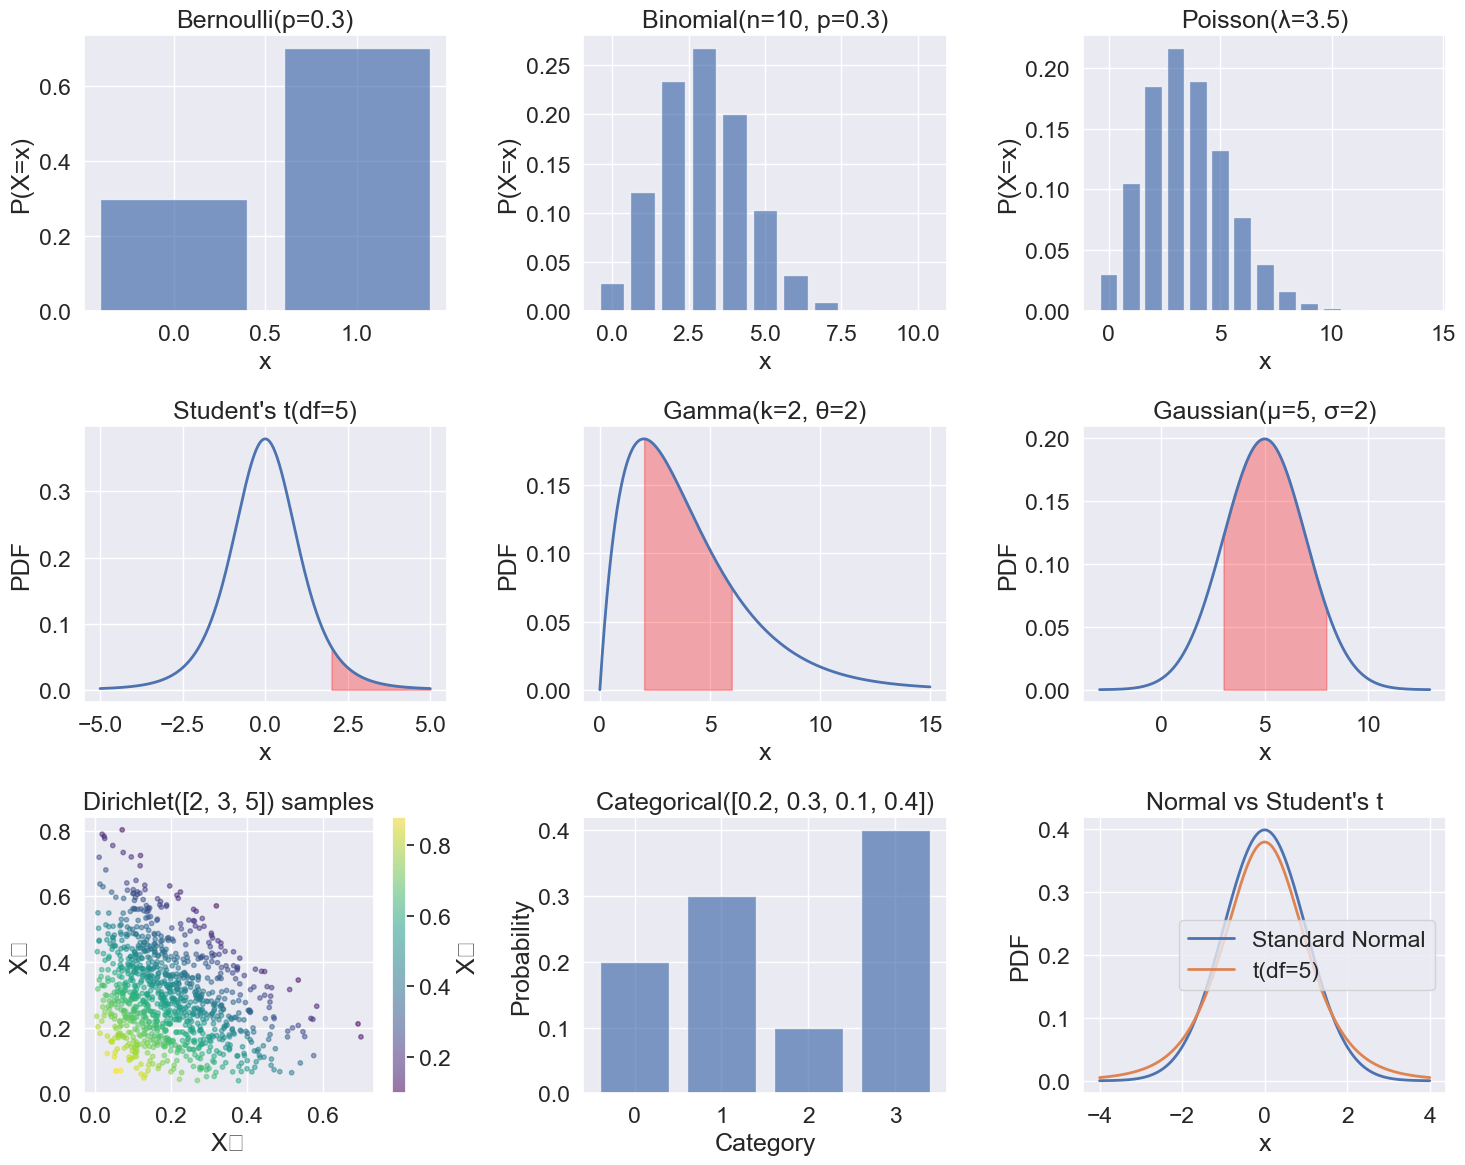



PRACTICAL EXAMPLES AND FORMULAS

Example 1: Mixture of Gaussians
P(X < 0) for Gaussian mixture: 0.309100

Example 2: Truncated Normal
P(X < 1) for Truncated Normal[-2,2]: 0.857616


QUICK REFERENCE CARD

DISCRETE DISTRIBUTIONS:
----------------------
1. Bernoulli(p):           P(X=1) = p, P(X=0) = 1-p
   scipy: stats.bernoulli(p)

2. Binomial(n,p):          P(X=k) = C(n,k) * p^k * (1-p)^(n-k)
   scipy: stats.binom(n, p)

3. Poisson(λ):             P(X=k) = e^(-λ) * λ^k / k!
   scipy: stats.poisson(lambda)

4. Categorical(p1,...,pk): P(X=i) = pi
   scipy: stats.multinomial(1, [p1,...,pk])
   numpy: np.random.choice(k, p=[p1,...,pk])

CONTINUOUS DISTRIBUTIONS:
------------------------
5. Student's t(df):        Complex formula, heavy tails
   scipy: stats.t(df)

6. Gamma(k,θ):            f(x) = x^(k-1) * e^(-x/θ) / (θ^k * Γ(k))
   scipy: stats.gamma(a=k, scale=θ)

7. Gaussian/Normal(μ,σ):   f(x) = (1/√(2πσ²)) * e^(-(x-μ)²/(2σ²))
   scipy: stats.norm(loc=μ, scale=σ)

8. Beta(α,β):      

In [142]:
import numpy as np
from scipy import stats
from scipy.integrate import quad
import matplotlib.pyplot as plt

# ===========================
# DISCRETE DISTRIBUTIONS
# ===========================

print("DISCRETE DISTRIBUTIONS")
print("=" * 50)

# 1. Bernoulli Distribution
print("\n1. Bernoulli Distribution")
print("-" * 25)
p = 0.7
bernoulli_dist = stats.bernoulli(p)

# For discrete distributions, we use PMF (Probability Mass Function)
print(f"P(X = 1) for Bernoulli(p={p}): {bernoulli_dist.pmf(1):.6f}")
print(f"P(X = 0) for Bernoulli(p={p}): {bernoulli_dist.pmf(0):.6f}")
print(f"P(X ≤ 0) for Bernoulli(p={p}): {bernoulli_dist.cdf(0):.6f}")

# 2. Binomial Distribution
print("\n2. Binomial Distribution")
print("-" * 25)
n, p = 10, 0.3
binomial_dist = stats.binom(n, p)

print(f"P(X = 5) for Binomial(n={n}, p={p}): {binomial_dist.pmf(5):.6f}")
print(f"P(X ≤ 5) for Binomial(n={n}, p={p}): {binomial_dist.cdf(5):.6f}")
print(f"P(3 ≤ X ≤ 7) for Binomial(n={n}, p={p}): {binomial_dist.cdf(7) - binomial_dist.cdf(2):.6f}")
print(f"P(X > 5) for Binomial(n={n}, p={p}): {1 - binomial_dist.cdf(5):.6f}")

# 3. Poisson Distribution
print("\n3. Poisson Distribution")
print("-" * 25)
lambda_param = 3.5
poisson_dist = stats.poisson(lambda_param)

print(f"P(X = 3) for Poisson(λ={lambda_param}): {poisson_dist.pmf(3):.6f}")
print(f"P(X ≤ 5) for Poisson(λ={lambda_param}): {poisson_dist.cdf(5):.6f}")
print(f"P(X > 5) for Poisson(λ={lambda_param}): {1 - poisson_dist.cdf(5):.6f}")

# 4. Categorical (Multinomial with n=1)
print("\n4. Categorical Distribution")
print("-" * 25)
# For categorical, we use multinomial with n=1
categories = [0.2, 0.3, 0.1, 0.4]  # probabilities for each category
categorical_dist = stats.multinomial(n=1, p=categories)

# Example: probability of getting category 2 (index 1)
print(f"P(category=2) for Categorical({categories}): {categories[1]:.6f}")

# For more complex categorical probabilities
sample_outcome = [0, 1, 0, 0]  # category 2 occurred
print(f"P(X = category 2) using multinomial: {categorical_dist.pmf(sample_outcome):.6f}")

# Alternative: use numpy for simple categorical sampling
n_samples = 10000
categorical_samples = np.random.choice(len(categories), size=n_samples, p=categories)
print(f"Empirical P(category=2): {np.mean(categorical_samples == 1):.6f}")

# ===========================
# CONTINUOUS DISTRIBUTIONS
# ===========================

print("\n\nCONTINUOUS DISTRIBUTIONS")
print("=" * 50)

# 5. Student's t-distribution
print("\n5. Student's t-distribution")
print("-" * 25)
df = 5  # degrees of freedom
t_dist = stats.t(df)

print(f"P(X > 0) for t({df}): {1 - t_dist.cdf(0):.6f}")
print(f"P(-2 < X < 2) for t({df}): {t_dist.cdf(2) - t_dist.cdf(-2):.6f}")
print(f"P(|X| > 2) for t({df}): {2 * (1 - t_dist.cdf(2)):.6f}")  # two-tailed

# 6. Gamma Distribution
print("\n6. Gamma Distribution")
print("-" * 25)
shape, scale = 2, 2  # k (shape) and θ (scale)
gamma_dist = stats.gamma(a=shape, scale=scale)

print(f"P(X < 5) for Gamma(k={shape}, θ={scale}): {gamma_dist.cdf(5):.6f}")
print(f"P(X > 3) for Gamma(k={shape}, θ={scale}): {1 - gamma_dist.cdf(3):.6f}")
print(f"P(2 < X < 6) for Gamma(k={shape}, θ={scale}): {gamma_dist.cdf(6) - gamma_dist.cdf(2):.6f}")

# 7. Gaussian (Normal) Distribution
print("\n7. Gaussian (Normal) Distribution")
print("-" * 25)
mu, sigma = 5, 2
gaussian_dist = stats.norm(loc=mu, scale=sigma)

print(f"P(X > 7) for N(μ={mu}, σ={sigma}): {1 - gaussian_dist.cdf(7):.6f}")
print(f"P(|X - μ| < 2σ) for N(μ={mu}, σ={sigma}): {gaussian_dist.cdf(mu + 2*sigma) - gaussian_dist.cdf(mu - 2*sigma):.6f}")
print(f"P(3 < X < 8) for N(μ={mu}, σ={sigma}): {gaussian_dist.cdf(8) - gaussian_dist.cdf(3):.6f}")

# ===========================
# MULTIVARIATE DISTRIBUTIONS
# ===========================

print("\n\nMULTIVARIATE DISTRIBUTIONS")
print("=" * 50)

# 8. Dirichlet Distribution
print("\n8. Dirichlet Distribution")
print("-" * 25)
alpha = [2, 3, 5]  # concentration parameters
dirichlet_dist = stats.dirichlet(alpha)

# For Dirichlet, we often work with samples or specific regions
# Example: Generate samples and compute empirical probabilities
n_samples = 10000
dirichlet_samples = dirichlet_dist.rvs(size=n_samples)

# Probability that first component > 0.5
print(f"P(X₁ > 0.5) for Dirichlet({alpha}): {np.mean(dirichlet_samples[:, 0] > 0.5):.6f}")

# Probability that first component is largest
first_is_largest = np.all(dirichlet_samples[:, 0:1] > dirichlet_samples[:, 1:], axis=1)
print(f"P(X₁ > X₂ and X₁ > X₃): {np.mean(first_is_largest):.6f}")

# Mean of the distribution
mean = np.array(alpha) / np.sum(alpha)
print(f"Mean of Dirichlet({alpha}): {mean}")

# ===========================
# VISUALIZATION
# ===========================

plt.figure(figsize=(15, 12))

# Discrete distributions
plt.subplot(3, 3, 1)
x = np.arange(0, 2)
plt.bar(x, [bernoulli_dist.pmf(i) for i in x], alpha=0.7)
plt.title(f'Bernoulli(p={p})')
plt.xlabel('x')
plt.ylabel('P(X=x)')

plt.subplot(3, 3, 2)
x = np.arange(0, n+1)
plt.bar(x, binomial_dist.pmf(x), alpha=0.7)
plt.title(f'Binomial(n={n}, p={p})')
plt.xlabel('x')
plt.ylabel('P(X=x)')

plt.subplot(3, 3, 3)
x = np.arange(0, 15)
plt.bar(x, poisson_dist.pmf(x), alpha=0.7)
plt.title(f'Poisson(λ={lambda_param})')
plt.xlabel('x')
plt.ylabel('P(X=x)')

# Continuous distributions
plt.subplot(3, 3, 4)
x = np.linspace(-5, 5, 1000)
plt.plot(x, t_dist.pdf(x), 'b-', linewidth=2)
plt.fill_between(x[x > 2], t_dist.pdf(x[x > 2]), alpha=0.3, color='red')
plt.title(f"Student's t(df={df})")
plt.xlabel('x')
plt.ylabel('PDF')

plt.subplot(3, 3, 5)
x = np.linspace(0, 15, 1000)
plt.plot(x, gamma_dist.pdf(x), 'b-', linewidth=2)
plt.fill_between(x[(x > 2) & (x < 6)], gamma_dist.pdf(x[(x > 2) & (x < 6)]), alpha=0.3, color='red')
plt.title(f'Gamma(k={shape}, θ={scale})')
plt.xlabel('x')
plt.ylabel('PDF')

plt.subplot(3, 3, 6)
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
plt.plot(x, gaussian_dist.pdf(x), 'b-', linewidth=2)
plt.fill_between(x[(x > 3) & (x < 8)], gaussian_dist.pdf(x[(x > 3) & (x < 8)]), alpha=0.3, color='red')
plt.title(f'Gaussian(μ={mu}, σ={sigma})')
plt.xlabel('x')
plt.ylabel('PDF')

# Dirichlet visualization (2D simplex for 3 parameters)
plt.subplot(3, 3, 7)
plt.scatter(dirichlet_samples[:1000, 0], dirichlet_samples[:1000, 1], 
           alpha=0.5, s=10, c=dirichlet_samples[:1000, 2], cmap='viridis')
plt.colorbar(label='X₃')
plt.xlabel('X₁')
plt.ylabel('X₂')
plt.title(f'Dirichlet({alpha}) samples')

# Categorical visualization
plt.subplot(3, 3, 8)
plt.bar(range(len(categories)), categories, alpha=0.7)
plt.title(f'Categorical({categories})')
plt.xlabel('Category')
plt.ylabel('Probability')

# Combined visualization
plt.subplot(3, 3, 9)
x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.pdf(x), label='Standard Normal', linewidth=2)
plt.plot(x, t_dist.pdf(x), label=f't(df={df})', linewidth=2)
plt.legend()
plt.title('Normal vs Student\'s t')
plt.xlabel('x')
plt.ylabel('PDF')

plt.tight_layout()
plt.show()

# ===========================
# PRACTICAL EXAMPLES AND FORMULAS
# ===========================

print("\n\nPRACTICAL EXAMPLES AND FORMULAS")
print("=" * 50)

# Example 1: Mixture of distributions
print("\nExample 1: Mixture of Gaussians")
weights = [0.3, 0.7]
means = [-2, 3]
stds = [1, 1.5]

def mixture_gaussian_pdf(x):
    return sum(w * stats.norm.pdf(x, mu, sigma) 
               for w, mu, sigma in zip(weights, means, stds))

def mixture_gaussian_cdf(x):
    return sum(w * stats.norm.cdf(x, mu, sigma) 
               for w, mu, sigma in zip(weights, means, stds))

# Calculate probability for mixture
x_val = 0
print(f"P(X < {x_val}) for Gaussian mixture: {mixture_gaussian_cdf(x_val):.6f}")

# Example 2: Truncated distribution
print("\nExample 2: Truncated Normal")
def truncated_normal_cdf(x, mu, sigma, a, b):
    if x <= a:
        return 0
    elif x >= b:
        return 1
    else:
        return (stats.norm.cdf(x, mu, sigma) - stats.norm.cdf(a, mu, sigma)) / \
               (stats.norm.cdf(b, mu, sigma) - stats.norm.cdf(a, mu, sigma))

mu, sigma, a, b = 0, 1, -2, 2
x_val = 1
print(f"P(X < {x_val}) for Truncated Normal[{a},{b}]: {truncated_normal_cdf(x_val, mu, sigma, a, b):.6f}")

# ===========================
# QUICK REFERENCE CARD
# ===========================

print("\n\nQUICK REFERENCE CARD")
print("=" * 50)

reference = """
DISCRETE DISTRIBUTIONS:
----------------------
1. Bernoulli(p):           P(X=1) = p, P(X=0) = 1-p
   scipy: stats.bernoulli(p)

2. Binomial(n,p):          P(X=k) = C(n,k) * p^k * (1-p)^(n-k)
   scipy: stats.binom(n, p)

3. Poisson(λ):             P(X=k) = e^(-λ) * λ^k / k!
   scipy: stats.poisson(lambda)

4. Categorical(p1,...,pk): P(X=i) = pi
   scipy: stats.multinomial(1, [p1,...,pk])
   numpy: np.random.choice(k, p=[p1,...,pk])

CONTINUOUS DISTRIBUTIONS:
------------------------
5. Student's t(df):        Complex formula, heavy tails
   scipy: stats.t(df)

6. Gamma(k,θ):            f(x) = x^(k-1) * e^(-x/θ) / (θ^k * Γ(k))
   scipy: stats.gamma(a=k, scale=θ)

7. Gaussian/Normal(μ,σ):   f(x) = (1/√(2πσ²)) * e^(-(x-μ)²/(2σ²))
   scipy: stats.norm(loc=μ, scale=σ)

8. Beta(α,β):             f(x) = x^(α-1) * (1-x)^(β-1) / B(α,β)
   scipy: stats.beta(a=α, b=β)

MULTIVARIATE:
------------
9. Dirichlet(α1,...,αk):  Complex formula, generalizes Beta
   scipy: stats.dirichlet([α1,...,αk])

KEY METHODS:
-----------
- Discrete: pmf(k), cdf(k)
- Continuous: pdf(x), cdf(x)
- All: rvs(size=n) for sampling
- P(a < X ≤ b) = F(b) - F(a)
- P(X > a) = 1 - F(a)
"""

print(reference)

# ===========================
# COMMON PROBABILITY CALCULATIONS
# ===========================

print("\nCOMMON PROBABILITY CALCULATIONS")
print("=" * 50)

# Helper functions for common calculations
def prob_between(dist, a, b):
    """P(a < X ≤ b) for any distribution"""
    return dist.cdf(b) - dist.cdf(a)

def prob_greater_than(dist, a):
    """P(X > a) for any distribution"""
    return 1 - dist.cdf(a)

def prob_less_than(dist, b):
    """P(X ≤ b) for any distribution"""
    return dist.cdf(b)

def prob_in_std_range(dist, n_std=2):
    """P(|X - μ| < n*σ) for distributions with mean and std"""
    if hasattr(dist, 'mean') and hasattr(dist, 'std'):
        mu, sigma = dist.mean(), dist.std()
        return prob_between(dist, mu - n_std*sigma, mu + n_std*sigma)
    else:
        raise ValueError("Distribution must have mean() and std() methods")

# Example usage
normal = stats.norm(5, 2)
print(f"P(|X - μ| < 2σ) for Normal(5,2): {prob_in_std_range(normal, 2):.6f}")
print(f"P(3 < X ≤ 7) for Normal(5,2): {prob_between(normal, 3, 7):.6f}")

ANALYTICAL MARGINAL LIKELIHOOD CALCULATIONS

1. Bernoulli-Beta Model
-------------------------
Data: [1 0 1 1 0 1 1 1]
Prior: Beta(2, 2)
Marginal likelihood: 0.004545

2. Gaussian-Gaussian Model (Known Variance)
----------------------------------------
Data mean: 4.622
Prior: N(0, 10)
Known variance: 1
Marginal likelihood: 1.625709e-07

3. Poisson-Gamma Model
-------------------------
Data mean: 3.733
Prior: Gamma(2, 1)
Marginal likelihood: 1.250041e-16

4. Categorical-Dirichlet Model
------------------------------
Observed counts: [10 15  5 20]
Prior: Dirichlet([2 2 2 2])
Marginal likelihood: 3.820662e-30

5. Binomial-Beta Model
-------------------------
Successes: 7, Trials: 10
Prior: Beta(2, 2)
Marginal likelihood: 0.111888

6. Gaussian with Normal-Inverse-Gamma Prior
----------------------------------------
Data: mean=4.865, std=2.088
Prior: NIG(0, 1, 3, 2)
Marginal likelihood: 6.671338e-23


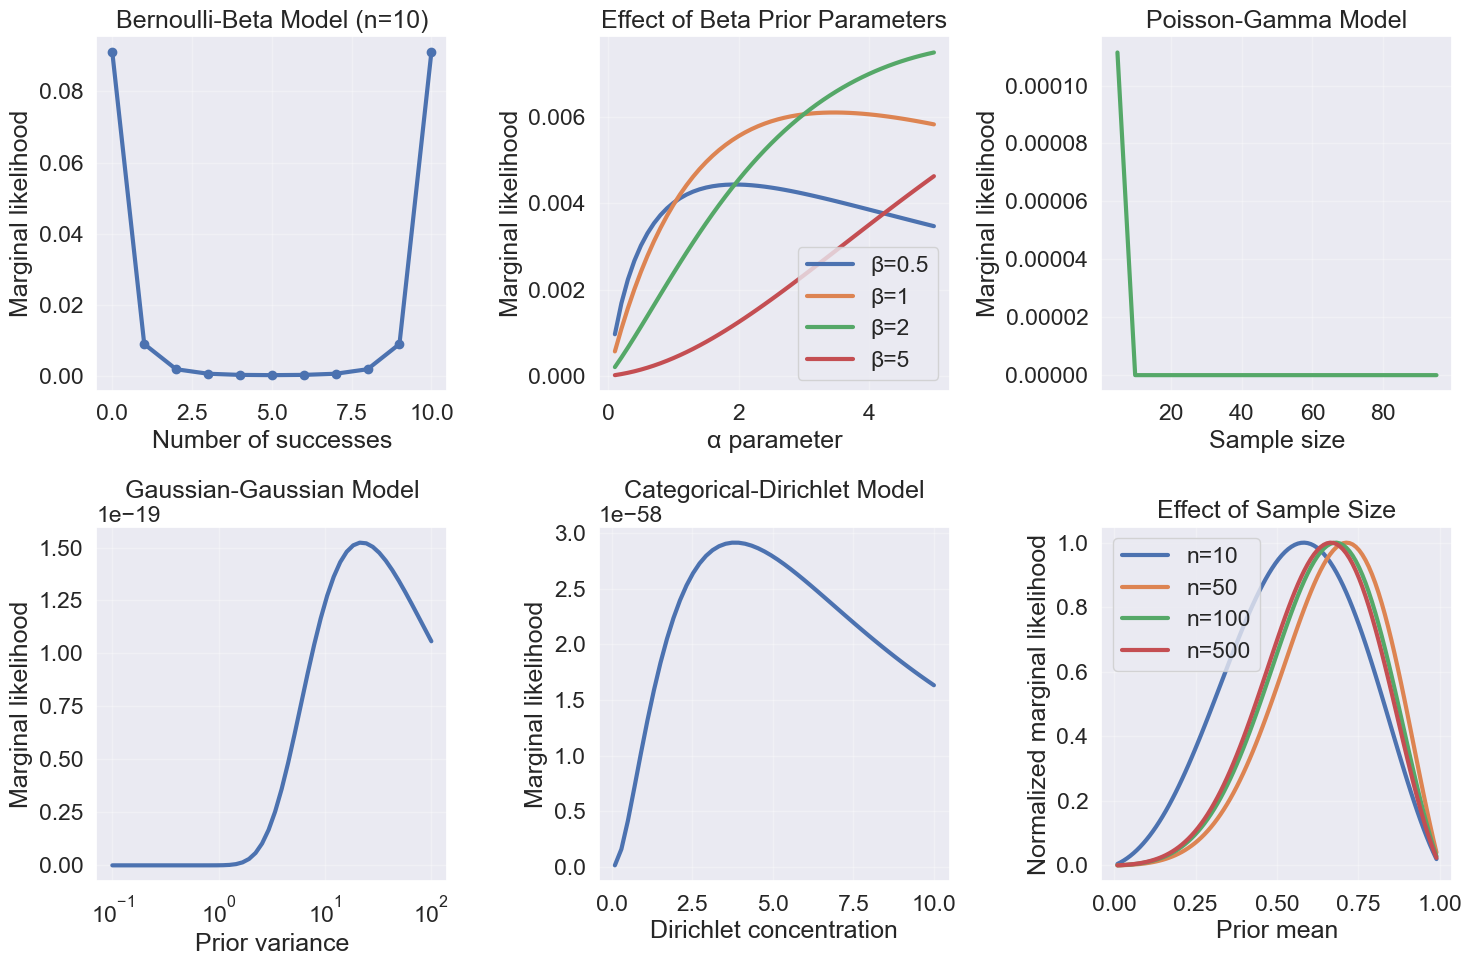



SUMMARY OF ANALYTICAL MARGINAL LIKELIHOODS

1. BERNOULLI-BETA MODEL:
   Data: X_i ~ Bernoulli(θ), i = 1,...,n
   Prior: θ ~ Beta(α, β)
   Marginal: P(data|α,β) = B(k+α, n-k+β) / B(α,β)
   where k = number of successes, B = beta function

2. BINOMIAL-BETA MODEL:
   Data: K ~ Binomial(n, θ)
   Prior: θ ~ Beta(α, β)
   Marginal: P(k|n,α,β) = C(n,k) * B(k+α, n-k+β) / B(α,β)

3. POISSON-GAMMA MODEL:
   Data: X_i ~ Poisson(λ), i = 1,...,n
   Prior: λ ~ Gamma(α, β)
   Marginal: P(data|α,β) = [Γ(Σx_i + α) * β^α] / [Γ(α) * Π(x_i!) * (n+β)^(Σx_i + α)]

4. GAUSSIAN-GAUSSIAN MODEL (known variance):
   Data: X_i ~ N(μ, σ²), i = 1,...,n (σ² known)
   Prior: μ ~ N(μ₀, σ₀²)
   Marginal: P(data|μ₀,σ₀²,σ²) = N(x̄|μ₀, σ₀² + σ²/n) * Π N(x_i|x̄, σ²)

5. CATEGORICAL-DIRICHLET MODEL:
   Data: counts n₁,...,nₖ from Categorical(θ)
   Prior: θ ~ Dirichlet(α)
   Marginal: P(data|α) = [Γ(Σα_i) * Π Γ(n_i + α_i)] / [Π Γ(α_i) * Γ(n + Σα_i)]

6. GAUSSIAN WITH NORMAL-INVERSE-GAMMA PRIOR:
   Data: X_i ~ N(μ, σ²), i =

In [143]:
import numpy as np
from scipy import stats
from scipy.special import gamma, betaln, gammaln
import matplotlib.pyplot as plt

# ===========================
# CONJUGATE PRIOR EXAMPLES
# ===========================

print("ANALYTICAL MARGINAL LIKELIHOOD CALCULATIONS")
print("=" * 50)

# 1. Bernoulli with Beta Prior
print("\n1. Bernoulli-Beta Model")
print("-" * 25)

def bernoulli_beta_marginal(data, alpha, beta_param):
    """
    Marginal likelihood for Bernoulli data with Beta prior
    
    Model: X_i ~ Bernoulli(θ)
    Prior: θ ~ Beta(α, β)
    
    Returns: P(data | α, β)
    """
    n = len(data)
    n_success = np.sum(data)
    n_failure = n - n_success
    
    # Using log for numerical stability
    log_marginal = (betaln(n_success + alpha, n_failure + beta_param) - 
                    betaln(alpha, beta_param))
    
    return np.exp(log_marginal)

# Example
data = np.array([1, 0, 1, 1, 0, 1, 1, 1])
alpha, beta_param = 2, 2
marginal = bernoulli_beta_marginal(data, alpha, beta_param)
print(f"Data: {data}")
print(f"Prior: Beta({alpha}, {beta_param})")
print(f"Marginal likelihood: {marginal:.6f}")

# 2. Gaussian with Known Variance, Gaussian Prior on Mean
print("\n2. Gaussian-Gaussian Model (Known Variance)")
print("-" * 40)

def gaussian_gaussian_marginal(data, prior_mean, prior_var, known_var):
    """
    Marginal likelihood for Gaussian data with Gaussian prior on mean
    
    Model: X_i ~ N(μ, σ²) where σ² is known
    Prior: μ ~ N(μ₀, σ₀²)
    
    Returns: P(data | μ₀, σ₀², σ²)
    """
    n = len(data)
    data_mean = np.mean(data)
    
    # Posterior parameters
    posterior_var = 1/(1/prior_var + n/known_var)
    
    # Marginal likelihood
    marginal_var = prior_var + known_var/n
    
    log_marginal = (-0.5 * n * np.log(2*np.pi*known_var) - 
                    0.5 * np.log(1 + n*prior_var/known_var) -
                    0.5 * np.sum((data - data_mean)**2)/known_var -
                    0.5 * n * (data_mean - prior_mean)**2 / (n*prior_var + known_var))
    
    return np.exp(log_marginal)

# Example
data = np.random.normal(5, 1, 10)
prior_mean, prior_var = 0, 10
known_var = 1
marginal = gaussian_gaussian_marginal(data, prior_mean, prior_var, known_var)
print(f"Data mean: {np.mean(data):.3f}")
print(f"Prior: N({prior_mean}, {prior_var})")
print(f"Known variance: {known_var}")
print(f"Marginal likelihood: {marginal:.6e}")

# 3. Poisson with Gamma Prior
print("\n3. Poisson-Gamma Model")
print("-" * 25)

def poisson_gamma_marginal(data, alpha, beta):
    """
    Marginal likelihood for Poisson data with Gamma prior
    
    Model: X_i ~ Poisson(λ)
    Prior: λ ~ Gamma(α, β)
    
    Returns: P(data | α, β)
    """
    n = len(data)
    sum_data = np.sum(data)
    
    # Using log for numerical stability
    log_marginal = (gammaln(sum_data + alpha) - gammaln(alpha) - 
                    np.sum(gammaln(data + 1)) + 
                    alpha * np.log(beta) - 
                    (sum_data + alpha) * np.log(n + beta))
    
    return np.exp(log_marginal)

# Example
data = np.random.poisson(3, 15)
alpha, beta = 2, 1
marginal = poisson_gamma_marginal(data, alpha, beta)
print(f"Data mean: {np.mean(data):.3f}")
print(f"Prior: Gamma({alpha}, {beta})")
print(f"Marginal likelihood: {marginal:.6e}")

# 4. Categorical with Dirichlet Prior
print("\n4. Categorical-Dirichlet Model")
print("-" * 30)

def categorical_dirichlet_marginal(counts, alpha):
    """
    Marginal likelihood for categorical data with Dirichlet prior
    
    Model: X_i ~ Categorical(θ)
    Prior: θ ~ Dirichlet(α)
    
    counts: array of counts for each category
    alpha: array of Dirichlet parameters
    
    Returns: P(data | α)
    """
    # Using log for numerical stability
    log_marginal = (gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) +
                    np.sum(gammaln(counts + alpha)) - 
                    gammaln(np.sum(counts + alpha)))
    
    return np.exp(log_marginal)

# Example
counts = np.array([10, 15, 5, 20])  # observed counts for each category
alpha = np.array([2, 2, 2, 2])      # Dirichlet parameters
marginal = categorical_dirichlet_marginal(counts, alpha)
print(f"Observed counts: {counts}")
print(f"Prior: Dirichlet({alpha})")
print(f"Marginal likelihood: {marginal:.6e}")

# 5. Binomial with Beta Prior
print("\n5. Binomial-Beta Model")
print("-" * 25)

def binomial_beta_marginal(k, n, alpha, beta_param):
    """
    Marginal likelihood for binomial data with Beta prior
    
    Model: K ~ Binomial(n, θ)
    Prior: θ ~ Beta(α, β)
    
    Returns: P(k | n, α, β)
    """
    # Log of binomial coefficient
    log_binom_coeff = gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)
    
    # Log marginal likelihood
    log_marginal = (log_binom_coeff + 
                    betaln(k + alpha, n - k + beta_param) - 
                    betaln(alpha, beta_param))
    
    return np.exp(log_marginal)

# Example
k, n = 7, 10
alpha, beta_param = 2, 2
marginal = binomial_beta_marginal(k, n, alpha, beta_param)
print(f"Successes: {k}, Trials: {n}")
print(f"Prior: Beta({alpha}, {beta_param})")
print(f"Marginal likelihood: {marginal:.6f}")

# ===========================
# GAUSSIAN WITH UNKNOWN MEAN AND VARIANCE
# ===========================

print("\n6. Gaussian with Normal-Inverse-Gamma Prior")
print("-" * 40)

def gaussian_nig_marginal(data, mu0, lambda0, alpha0, beta0):
    """
    Marginal likelihood for Gaussian data with Normal-Inverse-Gamma prior
    
    Model: X_i ~ N(μ, σ²)
    Prior: μ|σ² ~ N(μ₀, σ²/λ₀)
           σ² ~ InverseGamma(α₀, β₀)
    
    Returns: P(data | μ₀, λ₀, α₀, β₀)
    """
    n = len(data)
    data_mean = np.mean(data)
    data_var = np.var(data, ddof=0)  # Population variance
    
    # Update parameters
    lambda_n = lambda0 + n
    mu_n = (lambda0 * mu0 + n * data_mean) / lambda_n
    alpha_n = alpha0 + n/2
    beta_n = beta0 + 0.5 * n * data_var + 0.5 * lambda0 * n * (data_mean - mu0)**2 / lambda_n
    
    # Log marginal likelihood (Student's t-distribution)
    log_marginal = (gammaln(alpha_n) - gammaln(alpha0) + 
                    alpha0 * np.log(beta0) - alpha_n * np.log(beta_n) +
                    0.5 * (np.log(lambda0) - np.log(lambda_n)) -
                    0.5 * n * np.log(2 * np.pi))
    
    return np.exp(log_marginal)

# Example
data = np.random.normal(5, 2, 20)
mu0, lambda0, alpha0, beta0 = 0, 1, 3, 2
marginal = gaussian_nig_marginal(data, mu0, lambda0, alpha0, beta0)
print(f"Data: mean={np.mean(data):.3f}, std={np.std(data):.3f}")
print(f"Prior: NIG({mu0}, {lambda0}, {alpha0}, {beta0})")
print(f"Marginal likelihood: {marginal:.6e}")

# ===========================
# VISUALIZATION OF MARGINAL LIKELIHOOD
# ===========================

plt.figure(figsize=(15, 10))

# Plot 1: Beta-Bernoulli marginal likelihood as function of data
plt.subplot(2, 3, 1)
n_trials = 10
alpha, beta_param = 1, 1  # Uniform prior
successes = np.arange(0, n_trials + 1)
marginals = []

for k in successes:
    data = np.concatenate([np.ones(k), np.zeros(n_trials - k)])
    marginals.append(bernoulli_beta_marginal(data, alpha, beta_param))

plt.plot(successes, marginals, 'bo-')
plt.xlabel('Number of successes')
plt.ylabel('Marginal likelihood')
plt.title(f'Bernoulli-Beta Model (n={n_trials})')
plt.grid(True, alpha=0.3)

# Plot 2: Effect of prior parameters on marginal likelihood
plt.subplot(2, 3, 2)
data = np.array([1, 0, 1, 1, 0, 1, 1, 1])  # Fixed data
alphas = np.linspace(0.1, 5, 50)
betas = [0.5, 1, 2, 5]

for beta_val in betas:
    marginals = [bernoulli_beta_marginal(data, alpha, beta_val) for alpha in alphas]
    plt.plot(alphas, marginals, label=f'β={beta_val}')

plt.xlabel('α parameter')
plt.ylabel('Marginal likelihood')
plt.title('Effect of Beta Prior Parameters')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Poisson-Gamma marginal likelihood
plt.subplot(2, 3, 3)
true_lambda = 3
sample_sizes = np.arange(5, 100, 5)
alpha, beta = 3, 1  # Prior

marginals = []
for n in sample_sizes:
    data = np.random.poisson(true_lambda, n)
    marginals.append(poisson_gamma_marginal(data, alpha, beta))

plt.plot(sample_sizes, marginals, 'g-')
plt.xlabel('Sample size')
plt.ylabel('Marginal likelihood')
plt.title('Poisson-Gamma Model')
plt.grid(True, alpha=0.3)

# Plot 4: Gaussian marginal likelihood with different priors
plt.subplot(2, 3, 4)
true_mean = 5
true_std = 1
data = np.random.normal(true_mean, true_std, 30)

prior_vars = np.logspace(-1, 2, 50)
marginals = []

for prior_var in prior_vars:
    marginals.append(gaussian_gaussian_marginal(data, 0, prior_var, true_std**2))

plt.semilogx(prior_vars, marginals)
plt.xlabel('Prior variance')
plt.ylabel('Marginal likelihood')
plt.title('Gaussian-Gaussian Model')
plt.grid(True, alpha=0.3)

# Plot 5: Categorical-Dirichlet with different concentration
plt.subplot(2, 3, 5)
counts = np.array([20, 30, 10, 40])
concentrations = np.linspace(0.1, 10, 50)

marginals = []
for conc in concentrations:
    alpha = np.ones(4) * conc
    marginals.append(categorical_dirichlet_marginal(counts, alpha))

plt.plot(concentrations, marginals)
plt.xlabel('Dirichlet concentration')
plt.ylabel('Marginal likelihood')
plt.title('Categorical-Dirichlet Model')
plt.grid(True, alpha=0.3)

# Plot 6: Comparison of different sample sizes
plt.subplot(2, 3, 6)
true_p = 0.7
alpha, beta_param = 1, 1  # Uniform prior
sample_sizes = [10, 50, 100, 500]

for n in sample_sizes:
    data = np.random.binomial(1, true_p, n)
    prior_ps = np.linspace(0.01, 0.99, 100)
    marginals = []
    
    for p in prior_ps:
        # Convert p to alpha, beta for Beta distribution with mean p
        a = p * 5  # Arbitrary choice of concentration
        b = (1-p) * 5
        marginals.append(bernoulli_beta_marginal(data, a, b))
    
    plt.plot(prior_ps, marginals / np.max(marginals), label=f'n={n}')

plt.xlabel('Prior mean')
plt.ylabel('Normalized marginal likelihood')
plt.title('Effect of Sample Size')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===========================
# SUMMARY OF ANALYTICAL FORMULAS
# ===========================

print("\n\nSUMMARY OF ANALYTICAL MARGINAL LIKELIHOODS")
print("=" * 50)

summary = """
1. BERNOULLI-BETA MODEL:
   Data: X_i ~ Bernoulli(θ), i = 1,...,n
   Prior: θ ~ Beta(α, β)
   Marginal: P(data|α,β) = B(k+α, n-k+β) / B(α,β)
   where k = number of successes, B = beta function

2. BINOMIAL-BETA MODEL:
   Data: K ~ Binomial(n, θ)
   Prior: θ ~ Beta(α, β)
   Marginal: P(k|n,α,β) = C(n,k) * B(k+α, n-k+β) / B(α,β)

3. POISSON-GAMMA MODEL:
   Data: X_i ~ Poisson(λ), i = 1,...,n
   Prior: λ ~ Gamma(α, β)
   Marginal: P(data|α,β) = [Γ(Σx_i + α) * β^α] / [Γ(α) * Π(x_i!) * (n+β)^(Σx_i + α)]

4. GAUSSIAN-GAUSSIAN MODEL (known variance):
   Data: X_i ~ N(μ, σ²), i = 1,...,n (σ² known)
   Prior: μ ~ N(μ₀, σ₀²)
   Marginal: P(data|μ₀,σ₀²,σ²) = N(x̄|μ₀, σ₀² + σ²/n) * Π N(x_i|x̄, σ²)

5. CATEGORICAL-DIRICHLET MODEL:
   Data: counts n₁,...,nₖ from Categorical(θ)
   Prior: θ ~ Dirichlet(α)
   Marginal: P(data|α) = [Γ(Σα_i) * Π Γ(n_i + α_i)] / [Π Γ(α_i) * Γ(n + Σα_i)]

6. GAUSSIAN WITH NORMAL-INVERSE-GAMMA PRIOR:
   Data: X_i ~ N(μ, σ²), i = 1,...,n
   Prior: μ|σ² ~ N(μ₀, σ²/λ₀), σ² ~ IG(α₀, β₀)
   Marginal: Student's t-distribution with specific parameters

KEY INSIGHTS:
------------
- Conjugate priors lead to closed-form marginal likelihoods
- Use log-space calculations for numerical stability
- Marginal likelihood balances model fit and complexity
- Can be used for model comparison and hyperparameter optimization
"""

print(summary)

# ===========================
# PRACTICAL USAGE EXAMPLES
# ===========================

print("\nPRACTICAL USAGE EXAMPLES")
print("=" * 50)

# Example: Model comparison using marginal likelihood
print("\nModel Comparison Example:")
print("-" * 25)

# Generate data from a biased coin
true_p = 0.7
data = np.random.binomial(1, true_p, 50)
print(f"Generated data: {np.sum(data)} successes out of {len(data)} trials")

# Compare different prior beliefs
priors = [
    ("Uniform", 1, 1),
    ("Weakly informative", 2, 2),
    ("Strong belief p=0.5", 10, 10),
    ("Strong belief p=0.7", 14, 6)
]

print("\nMarginal likelihoods under different priors:")
for name, alpha, beta in priors:
    ml = bernoulli_beta_marginal(data, alpha, beta)
    print(f"{name:20} Beta({alpha}, {beta}): {ml:.6e}")

# Bayes factor comparison
ml_uniform = bernoulli_beta_marginal(data, 1, 1)
ml_informed = bernoulli_beta_marginal(data, 14, 6)
bayes_factor = ml_informed / ml_uniform
print(f"\nBayes factor (informed vs uniform): {bayes_factor:.3f}")

# Example: Hyperparameter optimization
print("\n\nHyperparameter Optimization Example:")
print("-" * 35)

# Find optimal Gamma prior for Poisson data
data = np.array([2, 3, 1, 4, 3, 5, 2, 3, 4, 3])
print(f"Poisson data: {data}")

# Grid search over hyperparameters
alphas = np.linspace(0.1, 10, 50)
betas = np.linspace(0.1, 5, 50)

max_ml = -np.inf
best_alpha = None
best_beta = None

for alpha in alphas:
    for beta in betas:
        ml = poisson_gamma_marginal(data, alpha, beta)
        if ml > max_ml:
            max_ml = ml
            best_alpha = alpha
            best_beta = beta

print(f"Optimal prior: Gamma({best_alpha:.3f}, {best_beta:.3f})")
print(f"Maximum marginal likelihood: {max_ml:.6e}")